>  # **Natural Language Processing**

**Processamento de Linguagem Natural é um campo da inteligência artificial que estuda as interações entre computadores e linguagens humanas, em particular como programar computadores para processar e analisar grandes quantidades de dados de linguagem natural. NLP  aplicada para a classificação do texto atribui categorias aos dados do texto de acordo com seu conteúdo. 
Nesta aplicação será explicado métodos para analisar o texto e extrair recursos que podem ser usados para construir um modelo de classificação.**

#**DADOS**
* A base de dados foi coletada a partir do Portal da Transparência do Tribunal de Contas de São Paulo, que pode ser acessado através do link: http://www4.tce.sp.gov.br/licitacao/contratos
* O dataset contém informações relacionadas a base de dados de contratos enviadas pelos municípios do Estado de São Paulo

# **Objetivo**
* Implementar técnicas de pré-processamento de nlp e o algoritmo de Naive Bayes multinomial para a classificação de contratos a partir da descrição de seus objetos

# **Importar bibliotecas**

In [ ]:
#Biblioteca para a importação dos dados
import pandas as pd

#Biblioteca para gerar gráficos e visualizações
import matplotlib.pyplot as plt

#Biblioteca para remover pontuações
from string import punctuation

#Biblioteca para o processamento de linguagem natural
import nltk
#Tokenization e distribuições de frequência
from nltk import tokenize, FreqDist

#Biblioteca para gerar a WordCloud
from wordcloud.wordcloud import WordCloud

#Biblioteca importada SKLEARN para análise dos dados
#Vetorização dos dados
from sklearn.feature_extraction.text import CountVectorizer
#Modelo de Naive Bayes
from sklearn.naive_bayes import MultinomialNB
#Métricas 
from sklearn import metrics
#Validação cruzada
from sklearn.model_selection import cross_val_predict

# **Ferramenta NLTK**
* Recurso para o processamento de textos, a NLTK será útil para remoção de stopwords, separar o texto em sentenças, separar as palavras dentro de cada sentença, para representar e processar informações probabilísticas

Documentação: https://www.nltk.org

In [ ]:
nltk.download()
#d all q

# **Importação da base de dados do TCE**

**Após a importação do Pandas é feita a importação e a leitura do arquivo. O comando read_csv lê o CSV e o armazena em um Dataframe**

In [ ]:
#Importando o arquivo direto do Google Drive
from google_drive_downloader import GoogleDriveDownloader as gdd
google_id = '1u7B93IFnCob1KebVQ0y_D2aHTRnwd-nD'
gdd.download_file_from_google_drive(file_id=google_id, 
                                    dest_path = '/content/terms-3.csv', 
                                    showsize = True)
df = pd.read_csv('/content/terms-3.csv' , delimiter=';', encoding='latin_1')

1.5 MiB Done.


**Head(): permite a visualização das primeiras linhas do DataFrame, o nome das colunas se encontra na primeira linha, a partir daí, podemos escolher quais colunas queremos trabalhar**

In [ ]:
#Exibir o dataset
df.head()

,Classificação,Número processo - TCA,Tipo,Termo nº,Espécie,Descrição da espécie,Modalidade da contratação,Nº do certame,Objeto,Interessado,Valor (R$),Vigência do termo,Data da assinatura,Data Publicação DOE,Base Legal / Observações,Ata do certame,Edital do certame,Post date
0,Informática,31630/026/10,Contrato,001/11,Termo Inicial,Inicial,Pregão Presencial,73/10,Aquisição de 10 (dez) microcomputadores de alt...,Acc Brasil Indústria e Comércio de Computador...,"R$ 84.530,00(valor total)",Vigência: A partir da data da publicação ao té...,27/01/2011,29/01/2011,Leis Federais nº. 10.520/02 e nº. 8.666/93,NaN,NaN,15/06/2015
1,Informática,31630/026/10,Contrato,001/11,Aditamento,1º Termo de Aditamento,Não se aplica,00/00,Acrécimo de um microcomputador ao contrato de ...,Acc Brasil Indústria e Comércio de Computador...,"Acréscimos:R$ 8.453,00(valor total)",A partir da assinatura,20/04/2011,26/04/2011,"Alínea ""b"" do Inciso I e §1º do artigo 65 da L...",NaN,NaN,15/06/2015
2,Informática,31630/026/10,Contrato,001/11,Aditamento,2º Termo de Aditamento,Não se aplica,00/00,Acrécimo de um microcomputador ao contrato de ...,Acc Brasil Indústria e Comércio de Computador...,"Acréscimos:R$ 8.453,00(valor total)",A partir da assinatura,18/11/2011,22/11/2011,"Alínea ""b"" do Inciso I e §1º do artigo 65 da L...",NaN,NaN,15/06/2015
3,Limpeza,41153/026/10,Contrato,003/11,Termo Inicial,Inicial,Pregão Presencial,77/10,"Prestação de serviços de limpeza, asseio e con...",V.L.P. Serviços de Portaria e Limpeza com For...,"R$ 50.480,70(valor total)R$ 3.365,38(valor men...",2º dia útil a contar da data da publicação de ...,20/01/2011,21/01/2011,Leis Federais nº. 10.520/02 e nº. 8.666/93,NaN,NaN,15/06/2015
4,Limpeza,41153/026/10,Contrato,003/11,Aditamento,1º Termo de Aditamento - 1ª Prorrogação,Não se aplica,00/00,Prorrogação do contrato de Prestação de serviç...,V.L.P. Serviços de Portaria e Limpeza com For...,"R$ 56.082,60(valor total)R$ 3.738,84(valor men...",24/04/12 a 23/07/13,15/03/2012,17/03/2012,Inciso II do artigo 57 da Lei Federal nº 8.666/93,NaN,NaN,15/06/2015


# **Exploração dos dados**

**A função df.drop ([ ], axis = 1, inplace = True)
remove permanentemente as colunas**

In [ ]:
#Remover as colunas
df.drop(df.columns[[1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace = True)

**A função df.columns retorna uma lista com o nome de todas as colunas do arquivo de dados**

In [ ]:
#Exibir o nome das colunas
df.columns

Index(['Classificação', 'Modalidade da contratação', 'Objeto', 'Interessado'], dtype='object')

In [ ]:
#Exibir o dataset
df.head()

,Classificação,Modalidade da contratação,Objeto,Interessado
0,Informática,Pregão Presencial,Aquisição de 10 (dez) microcomputadores de alt...,Acc Brasil Indústria e Comércio de Computador...
1,Informática,Não se aplica,Acrécimo de um microcomputador ao contrato de ...,Acc Brasil Indústria e Comércio de Computador...
2,Informática,Não se aplica,Acrécimo de um microcomputador ao contrato de ...,Acc Brasil Indústria e Comércio de Computador...
3,Limpeza,Pregão Presencial,"Prestação de serviços de limpeza, asseio e con...",V.L.P. Serviços de Portaria e Limpeza com For...
4,Limpeza,Não se aplica,Prorrogação do contrato de Prestação de serviç...,V.L.P. Serviços de Portaria e Limpeza com For...


**Distribuição do dataset**

*   **%matplotlib inline: gera gráficos em imagens estáticas no notebook.**
*   **value_counts: conta a quantidade de linhas de cada classificação**
*   **plot(kind='bar'): gera um gráfico de barras**



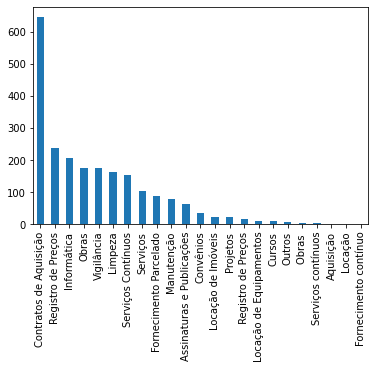

In [ ]:
#Gráficos de barras
%matplotlib inline
df.Classificação.value_counts().plot(kind='bar')

**Com o método info() conseguimos facilmente saber o nome de cada coluna, o número de linhas por coluna, se há valores nulos e o tipo de dado de cada uma dessas colunas. Por padrão ele tenta identificar o tipo de dado como int, float, datetime, ou object caso ele não consiga identificar o tipo exato. No final podemos observar a quantidade de memória utilizada para ler o arquivo.**

In [ ]:
#Informações do conjunto de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Classificação              2211 non-null   object
 1   Modalidade da contratação  2211 non-null   object
 2   Objeto                     2211 non-null   object
 3   Interessado                2211 non-null   object
dtypes: object(4)
memory usage: 69.2+ KB


**A função df.nunique retorna o número de valores únicos em cada coluna**

In [ ]:
#Valores únicos
df.nunique()

Classificação                  23
Modalidade da contratação      13
Objeto                       2081
Interessado                  1508
dtype: int64

##**Pré-processamento**
**Técnicas de pré-processamento são aplicadas para formatar e estruturar os textos, sem remover suas características naturais**

*  Etapas de pré processamento a serem realizadas de acordo com a análise do texto:
1. Remover acentos
2. Remover números, caracteres e pontuações
3. Remover stopwords



In [ ]:
#Função para remover acentos
def remover_acentos(txt):
        
      dicionario_acentos = {
      'á' : 'a', 'Á' : 'A', 'â' : 'a', 'Â' : 'A', 'à' : 'a', 'À' : 'A', 'ã' : 'a', 'Ã' : 'A',
      'é' : 'e', 'É' : 'E', 'ê' : 'e', 'Ê' : 'E', 'è' : 'e', 'È' : 'E',
      'í' : 'i', 'Í' : 'I', 'î' : 'i', 'Î' : 'I', 'ì' : 'i', 'Ì' : 'I',
      'ó' : 'o', 'Ó' : 'O', 'ô' : 'o', 'Ô' : 'O', 'ò' : 'o', 'Ò' : 'O', 'õ' : 'o', 'Õ' : 'O',
      'ú' : 'u', 'Ú' : 'U', 'û' : 'u', 'Û' : 'U', 'ù' : 'u', 'Ù' : 'U', 'ü' : 'u',
      'ç' : 'c','Ç' : 'C', 'ñ' : 'n','Ñ' : 'N'
      }
    
      for key, value in dicionario_acentos.items():

          if key in txt:
                txt = txt.replace(key, value)

      return txt
#Aplicar a função no dataset
df['Objeto']=df['Objeto'].apply(remover_acentos)

In [ ]:
df['Objeto'].head()

0    Aquisicao de 10 (dez) microcomputadores de alt...
1    Acrecimo de um microcomputador ao contrato de ...
2    Acrecimo de um microcomputador ao contrato de ...
3    Prestacao de servicos de limpeza, asseio e con...
4    Prorrogacao do contrato de Prestacao de servic...
Name: Objeto, dtype: object

**O método apply() permite que a função criada seja aplicada em todas as linhas da coluna indicada.**

In [ ]:
#Função para remover números, caracteres e pontuações
#print(list(punctuation))
def remover_numeros_pontuacao(txt):
        
        pontuacao = list(punctuation)
        
        dicionario_caracteres =['º', '¿','¾','¾','´','`','“','”','•','ª','–','ö','»','°','«','¬','®','¼','§', '½', '‘', '’', 'ø', '±', '—']
        for item in dicionario_caracteres:
            pontuacao.append(item)

        txt_r = ''.join([char for char in txt if not char.isdigit() and char not in pontuacao])

        return txt_r
#Aplicar a função no dataset
df['Objeto']=df['Objeto'].apply(remover_numeros_pontuacao)

**Stopwords são palavras utilizadas com muita frequência como: artigos, preposições, conjunções e  outras palavras auxiliares que não têm potencial para contribuir para a caracterização do conteúdo presente no texto**

In [ ]:
#Exibir as stopwords da nltk
stop= setstopwords = set(nltk.corpus.stopwords.words('portuguese'))
print(stop) 

{'eu', 'esta', 'havemos', 'não', 'há', 'aquilo', 'estas', 'esteja', 'ou', 'estão', 'depois', 'deles', 'mais', 'este', 'a', 'nosso', 'houverão', 'fosse', 'na', 'dele', 'uma', 'hão', 'houvera', 'isso', 'entre', 'estava', 'estivera', 'forem', 'houverem', 'isto', 'esse', 'teu', 'estivessem', 'sejamos', 'estavam', 'que', 'fomos', 'mas', 'sua', 'nós', 'terei', 'sou', 'qual', 'estivéssemos', 'tinham', 'pelo', 'estávamos', 'teríamos', 'estes', 'um', 'serei', 'houveremos', 'era', 'no', 'nossos', 'houvermos', 'tenha', 'houvesse', 'com', 'estou', 'delas', 'tivemos', 'tivessem', 'tiverem', 'para', 'esses', 'hajam', 'vos', 'serão', 'quando', 'tuas', 'seria', 'teve', 'estejam', 'estivermos', 'tive', 'teremos', 'tenhamos', 'nos', 'seriam', 'tinha', 'de', 'pela', 'houveram', 'são', 'tínhamos', 'tua', 'hajamos', 'em', 'lhe', 'fôramos', 'dela', 'como', 'te', 'fora', 'estivemos', 'minha', 'nossa', 'também', 'houvéramos', 'elas', 'estamos', 'tenho', 'essas', 'será', 'essa', 'minhas', 'seus', 'das', 'tiver

In [ ]:
#Função para remover stopwords
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))
#Aplicar a função no dataset
df['Objeto']=df['Objeto'].apply(RemoveStopWords)

In [ ]:
#Verificar se todas as funções foram aplicadas
df['Objeto'].head()

0    Aquisicao dez microcomputadores alto desempenh...
1    Acrecimo microcomputador contrato Aquisicao de...
2    Acrecimo microcomputador contrato Aquisicao de...
3    Prestacao servicos limpeza asseio conservacao ...
4    Prorrogacao contrato Prestacao servicos limpez...
Name: Objeto, dtype: object

#**Feature Engineering**

**Distribuição de frequência: retorna as palavras que ocorrem com a maior frequência no texto**

**Tokenization: separa o texto em tokens, segmentando as palavras**

In [ ]:
# Junta todos os textos em uma string
todas_palavras = ' '.join([texto for texto in df['Objeto']])
# Tokenizar para verificar a frequência de cada palavra
token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)
# Frequência das palavras
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                              "Frequência": list(frequencia.values())})
#  20 Palavras mais comuns na base de dados
df_frequencia.sort_values(by='Frequência', inplace=True, ascending=False)
df_frequencia.head(20)

**Wordcloud (nuvem de palavras): visualização dos dados onde o tamanho de cada palavra é determinado pela sua frequência em um texto, ou seja, quanto maior for a ocorrência daquela palavra maior será sua disposição na nuvem**


In [ ]:
def nuvem_palavras(texto, coluna_texto,sentimento):
    # Separar nuvem por sentimento
    texto = texto.query(f"Classificação == '{sentimento}'")
    # Junta todos os textos em uma string
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    # Gerar a nuvem de palavras
    nuvem_palvras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    # Plotar a nuvem de palavras
    plt.figure(figsize=(24,12))
    plt.imshow(nuvem_palvras, interpolation='none')
    plt.axis("off")
    plt.show()

In [ ]:
#A função abaixo retorna uma lista ordenada com o nome de cada tipo de classificação
sorted(set(df['Classificação']))

[' Registro de Preços',
 'Aquisição',
 'Assinaturas e Publicações',
 'Contratos de Aquisição',
 'Convênios',
 'Cursos',
 'Fornecimento Parcelado',
 'Fornecimento contínuo',
 'Informática',
 'Limpeza',
 'Locação',
 'Locação de Equipamentos',
 'Locação de Imóveis',
 'Manutenção',
 'Obras',
 'Obras ',
 'Outros',
 'Projetos',
 'Registro de Preços',
 'Serviços',
 'Serviços Contínuos',
 'Serviços contínuos',
 'Vigilância']

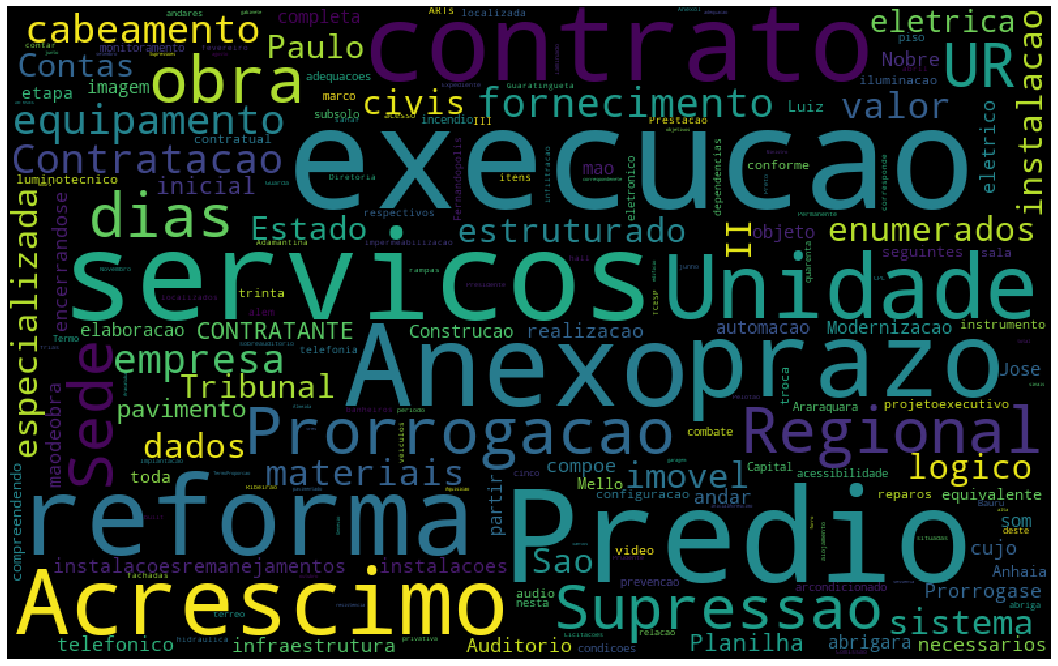

In [ ]:
#Exibir a nuvem de palavras de acordo com a classificação
nuvem_palavras(df, "Objeto", "Obras")

# **Modelo de Naive Bayes**
**É um classificador probabilístico baseado no Teorema de Bayes que será utilizado para a classificação dos textos. O modelo produz estimativas de probabilidade para cada classe. O algoritmo foi escolhido por apresentar melhor resultado em situações de classes múltiplas, regra de independência e por sua taxa de sucesso em comparação com outros algoritmos. O modelo multinomial trabalha com a frequência que cada termo ocorre no documento**


**Variáveis**

In [ ]:
#Declarar as variáveis
obj_contrato = df['Objeto'].values
clas_contrato = df['Classificação'].values

**Vetorização dos dados: converte cada palavra em vetores**
*   **O CountVectorizer é responsável pela vetorização dos dados, por transformar o texto em um vetor com base na frequência (contagem) de cada palavra que ocorre no texto e pela transformação dos dados em uma matriz de frequência**

In [ ]:
#Definição do vetorizador
vectorizer = CountVectorizer(analyzer= 'word')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

*   **O vectorizer.fit_transform aplica o vetorizador transformando os dados em uma matriz esparsa**

In [ ]:
#Aplicar o vetorizador
vect_obj = vectorizer.fit_transform(obj_contrato)

**Aplicar o modelo**

In [ ]:
#Naive Bayes Multinomial
modelo = MultinomialNB() 
modelo.fit(vect_obj, clas_contrato)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Testar o modelo**

In [ ]:
teste = ['Água 98', 'Acrécimo microcomputador contrato Aquisição', 'Prestação serviços limpeza asseio conservação']

In [ ]:
#transforma os dados de teste em vetores de palavras
vect_teste = vectorizer.transform(teste)

In [ ]:
#classificação com o modelo treinado
for a, b in zip(teste,modelo.predict(vect_teste)):
    print( a +', '+ b)

Água 98, Contratos de Aquisição
Acrécimo microcomputador contrato Aquisição, Informática
Prestação serviços limpeza asseio conservação, Limpeza


In [ ]:
#probabilidade de classificação em cada conjunto de dados de teste
print(modelo.classes_)
modelo.predict_proba(vect_teste).round(2)

[' Registro de Preços' 'Aquisição' 'Assinaturas e Publicações'
 'Contratos de Aquisição' 'Convênios' 'Cursos' 'Fornecimento Parcelado'
 'Fornecimento contínuo' 'Informática' 'Limpeza' 'Locação'
 'Locação de Equipamentos' 'Locação de Imóveis' 'Manutenção' 'Obras'
 'Obras ' 'Outros' 'Projetos' 'Registro de Preços' 'Serviços'
 'Serviços Contínuos' 'Serviços contínuos' 'Vigilância']


array([[0.01, 0.  , 0.03, 0.29, 0.02, 0.  , 0.04, 0.  , 0.09, 0.07, 0.  ,
        0.  , 0.01, 0.04, 0.08, 0.  , 0.  , 0.01, 0.11, 0.05, 0.07, 0.  ,
        0.08],
       [0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.6 , 0.07, 0.  ,
        0.  , 0.  , 0.03, 0.08, 0.  , 0.  , 0.  , 0.  , 0.03, 0.08, 0.  ,
        0.07],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ]])

**Validação e métricas do modelo**

**Validação Cruzada: técnica que visa entender como o modelo generaliza, ou seja, como ele se comporta ao prever um dado que nunca viu. Podemos fazer k combinações,  cada cruzamento retorna um valor que é a taxa de acerto daquela combinação.**

**Passamos como parâmetro dessa função o nosso modelo, os valores dos dados para treino e quantas combinações (cv) queremos que ela faça**

In [ ]:
#Validação cruzada 
resultados = cross_val_predict(modelo, vect_obj, clas_contrato, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


**A acurácia é a proporção de casos que foram corretamente previstos, sejam eles verdadeiro positivo ou verdadeiro negativo**

In [ ]:
#Métrica de acurácia do modelo
metrics.accuracy_score(clas_contrato,resultados)

0.8082315694255993

**A função metrics.classification_report retorna as seguintes métricas:**

* **Precisão: indica a relação entre as previsões positivas realizadas corretamente e todas as previsões positivas (incluindo as falsas).  A principal utilização desta métrica para o modelo é minimizar os falsos positivos, neste caso, quanto mais perto dos 100% chegarmos melhor.**

* **Recall: indica a relação entre as previsões positivas realizadas corretamente e todas as previsões que realmente são positivas (True Positives e False Negatives), indicando o quanto nosso modelo está identificando os casos positivos corretamente**

*  **O F1 Score: média harmônica entre precisão (que, apesar de ter o mesmo nome, não é a mesma citada acima) e recall**




In [ ]:
#Métrica de precisão do modelo
print(metrics.classification_report(clas_contrato,resultados))

                           precision    recall  f1-score   support

       Registro de Preços       0.00      0.00      0.00        17
                Aquisição       0.00      0.00      0.00         1
Assinaturas e Publicações       0.87      0.74      0.80        62
   Contratos de Aquisição       0.95      0.81      0.88       646
                Convênios       0.89      0.74      0.81        34
                   Cursos       0.00      0.00      0.00         8
   Fornecimento Parcelado       0.79      0.94      0.86        87
    Fornecimento contínuo       0.00      0.00      0.00         1
              Informática       0.70      0.86      0.77       206
                  Limpeza       0.90      0.96      0.93       162
                  Locação       0.00      0.00      0.00         1
  Locação de Equipamentos       0.70      0.78      0.74         9
       Locação de Imóveis       0.67      0.52      0.59        23
               Manutenção       0.78      0.76      0.77     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
